In [1]:
import os
import sys
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch
import matplotlib.pyplot as plt
from Naive_DAE import Naive_DAE,Dropout_DAE
import AE_Stats
from load_data_fn import load_data,load_data_no_filter

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
import importlib
import time
import ae_train
from losses import *
from telescope_torch import *

path = 'MIT_TTbar'
prefixed = [filename for filename in os.listdir(path) if filename.startswith("dt_norm")]

data = []
for p in prefixed:
    data.append([torch.load(f'{path}/{p}'),p])

In [2]:
path = '/uscms/home/nswood/nobackup/Notebooks/AE_Dev/models/batched_models/wafer_layer_split_mip_std_1_mean_nonzero'

models = os.listdir(path)[9:]

In [3]:

#all past 29
cur_train = []
for m in models:
    if int(m[10:]) > 12:
        cur_train.append(m)

In [4]:
#Calculating MSE of trained models
path = '/uscms/home/nswood/nobackup/Notebooks/AE_Dev/models/batched_models/wafer_layer_split_mip_std_1_mean_nonzero'

cur_model = models[1]

def get_data(data,cur_model):
    cur_data = []
    for d in data:
        if d[1] == cur_model:
            cur_data = d[0]
            break
    return cur_data

test_set = []
train_set = []
pred_set = []

for m in cur_train:
    cur_model = torch.load(os.path.join(path,m)).to('cpu')
    cur_data = get_data(data,m).to('cpu')
    if len(cur_data)< 10000:
        train_set.append(cur_data[0:int(0.8*len(cur_data))])
        test_data = cur_data[-int(0.19*len(cur_data)):]
        test_set.append(test_data)
    else:
        train_set.append(cur_data[0:int(0.8*10000)])

        test_data = cur_data[-int(0.19*10000):]
        test_set.append(test_data)
    
    
    
    

In [5]:
device = 'cuda'
train_dt = torch.vstack(train_set).to(device)
test_dt = torch.vstack(test_set).to(device)

In [6]:
def loss_p(data,pred,epoch,mean,std,alpha = 0.2,cut = 100):
    s = torch.sum(data[:,0:48],dim=1)
    s[s ==0.0000] = 1
    return new_loss(data,pred,epoch,mean,std) + 0.25*np.abs(torch.mean(torch.sum(pred-data[:,0:48],dim=1)/s).item()*100)

In [77]:
mean = 0
std = 1

In [79]:
size_1_train =len(train_dt)
size_1_test = len(test_dt)
train_loc = train_dt
test_loc = test_dt
# train = torch.vstack([train,largest[0:1000]] )
train_loc=train_loc[torch.randperm(train_loc.size()[0])]
test_loc=test_loc[torch.randperm(test_loc.size()[0])]
train_loc_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(train_loc)),
    batch_size=100,
    shuffle=False
)

test_loc_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(test_loc)),
    batch_size=100,
    shuffle=False
)

train_1 = train_dt[:,0:48]
test_1 = test_dt[:,0:48]
# train = torch.vstack([train,largest[0:1000]] )
train_1=train_1[torch.randperm(train_1.size()[0])]
test_1=test_1[torch.randperm(test_1.size()[0])]
train_1_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(train_1)),
    batch_size=100,
    shuffle=False
)

test_1_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(test_1)),
    batch_size=100,
    shuffle=False
)

In [17]:
def combo_loss(data,pred,epoch,mean,std,alpha = 0.2,cut = 50):
    error = dif_weighted_AE_MSE(data,pred,alpha = alpha)
    tele_loss = torch.mean(telescopeMSE2(data[:,0:48], pred))
    if epoch < cut:
        return error + tele_loss
    else:
        #Energy Conservation
        sum_dt, sum_pred = torch.sum(data, dim=1), torch.sum(pred,dim=1)
        sum_error = torch.mean(torch.norm(sum_dt-sum_pred))
        
    
        return  error + tele_loss + 0.01*sum_error*np.min([(epoch-cut)/cut,1])

In [85]:
loss = combo_loss

In [90]:
#fine-tune autoencoder
#batch 500

# model_1 = torch.load('models/dt_3_greater_0_450_250_100_dif_2').to(device)
# model_1.decoders.add_module('ReLU',nn.ReLU())
                        
# model_1 = Naive_DAE([48,450,150,16]).to(device)

# model_1 = torch.load('models/dt_1_greater_0_450_250_100_dif_2').to(device)

test = test_dt
lr = 8.5e-6
num_epochs = 400

optimizer = optim.Adam(model_1.parameters(), lr,weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.5)

all_1_test_losses = []
all_1_train_losses = []
# train
running_loss = float("inf")
for epoch in range(num_epochs):
    
    losses = []
    
    for i, data_list in enumerate(train_1_d1_flat):
        model_1.train()
        data = data_list[0]
        v_pred = model_1(data)
        
        batch_loss = loss(data[:,0:48], v_pred,epoch,mean,std)
        
        all_1_train_losses.append(batch_loss.item())
        losses.append(batch_loss.item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
    scheduler.step(batch_loss)
    data_1_test = test[:,0:48]
    model_1.eval()
    test_pred = model_1(data_1_test)
    batch_1_test = loss(data_1_test[:,0:48], test_pred,epoch,mean,std)
    all_1_test_losses.append(batch_1_test.item())
    running_loss = np.mean(losses)
    running_1est_loss = batch_1_test.item()
    
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    print(f"Epoch {epoch}: Train {running_loss}, Test {running_1est_loss}")
model_1.eval()
# torch.save(model_1,'models/combo_loss_high_mid')

# AE_Stats.gen_all_stats(model_1(dt_1[-size_1_test:,0:48]).cpu(),dt_1[-size_1_test:,0:48].cpu(),dt_1[-size_1_test:].cpu())

Epoch 0, lr 8.5e-06
Epoch 0: Train 5.748440052660144, Test 5.8440351486206055
Epoch 1, lr 8.5e-06
Epoch 1: Train 5.754191413412289, Test 5.55454158782959
Epoch 2, lr 8.5e-06
Epoch 2: Train 5.691687915617106, Test 5.666515350341797
Epoch 3, lr 8.5e-06
Epoch 3: Train 5.666551577363696, Test 5.443722248077393
Epoch 4, lr 8.5e-06
Epoch 4: Train 5.60370905686398, Test 5.419139385223389
Epoch 5, lr 8.5e-06
Epoch 5: Train 5.59834580078417, Test 5.397257328033447
Epoch 6, lr 8.5e-06
Epoch 6: Train 5.5510291564951135, Test 5.373698711395264
Epoch 7, lr 8.5e-06
Epoch 7: Train 5.519667926734807, Test 5.488041400909424
Epoch 8, lr 8.5e-06
Epoch 8: Train 5.50022118111046, Test 5.301029205322266
Epoch 9, lr 8.5e-06
Epoch 9: Train 5.477665158680507, Test 5.330437660217285
Epoch 10, lr 8.5e-06
Epoch 10: Train 5.455228830648928, Test 5.336417198181152
Epoch 11, lr 8.5e-06
Epoch 11: Train 5.452445739677974, Test 5.730915546417236
Epoch 12, lr 8.5e-06
Epoch 12: Train 5.416493799808074, Test 5.26919269561

Epoch 108, lr 8.5e-06
Epoch 108: Train 4.594322032758168, Test 7.571263790130615
Epoch 109, lr 8.5e-06
Epoch 109: Train 4.579411601168768, Test 7.556008338928223
Epoch 110, lr 8.5e-06
Epoch 110: Train 4.552149915865489, Test 7.520884037017822
Epoch 111, lr 8.5e-06
Epoch 111: Train 4.585388294726002, Test 7.478801250457764
Epoch 112, lr 8.5e-06
Epoch 112: Train 4.531215206944212, Test 7.5880537033081055
Epoch 113, lr 8.5e-06
Epoch 113: Train 4.563063242484112, Test 7.573978424072266
Epoch 114, lr 8.5e-06
Epoch 114: Train 4.547916908677744, Test 7.481121063232422
Epoch 115, lr 8.5e-06
Epoch 115: Train 4.530963736358954, Test 7.551760196685791
Epoch 116, lr 8.5e-06
Epoch 116: Train 4.5436704093096205, Test 7.450095176696777
Epoch 117, lr 8.5e-06
Epoch 117: Train 4.515099028470565, Test 7.51981258392334
Epoch 118, lr 8.5e-06
Epoch 118: Train 4.536588962272722, Test 7.531336784362793
Epoch 119, lr 8.5e-06
Epoch 119: Train 4.55257830790111, Test 7.534222602844238
Epoch 120, lr 8.5e-06
Epoch 

Epoch 209, lr 4.25e-06
Epoch 209: Train 4.175768097444457, Test 6.932697772979736
Epoch 210, lr 4.25e-06
Epoch 210: Train 4.155536224525802, Test 6.988583564758301
Epoch 211, lr 4.25e-06
Epoch 211: Train 4.156915456883762, Test 6.994184970855713
Epoch 212, lr 4.25e-06
Epoch 212: Train 4.158887442350387, Test 6.962202072143555
Epoch 213, lr 4.25e-06
Epoch 213: Train 4.15887106520789, Test 6.932325839996338
Epoch 214, lr 4.25e-06
Epoch 214: Train 4.1655095020362305, Test 6.984249114990234
Epoch 215, lr 4.25e-06
Epoch 215: Train 4.161480084779312, Test 6.937686920166016
Epoch 216, lr 4.25e-06
Epoch 216: Train 4.1527349975644325, Test 6.927280426025391
Epoch 217, lr 4.25e-06
Epoch 217: Train 4.148041667670619, Test 6.942466735839844
Epoch 218, lr 4.25e-06
Epoch 218: Train 4.15878988548201, Test 6.930168151855469
Epoch 219, lr 4.25e-06
Epoch 219: Train 4.152850554500307, Test 7.008701324462891
Epoch 220, lr 4.25e-06
Epoch 220: Train 4.142856628967791, Test 6.933549880981445
Epoch 221, lr 4.

Epoch 309, lr 4.25e-06
Epoch 309: Train 4.051799961571791, Test 6.7297563552856445
Epoch 310, lr 4.25e-06
Epoch 310: Train 4.043747406176158, Test 6.7595109939575195
Epoch 311, lr 4.25e-06
Epoch 311: Train 4.047179950037781, Test 6.737186431884766
Epoch 312, lr 4.25e-06
Epoch 312: Train 4.046831841347169, Test 6.7306928634643555
Epoch 313, lr 4.25e-06
Epoch 313: Train 4.045486910124215, Test 6.70765495300293
Epoch 314, lr 4.25e-06
Epoch 314: Train 4.043828870544628, Test 6.711397171020508
Epoch 315, lr 4.25e-06
Epoch 315: Train 4.044368077175958, Test 6.7008748054504395
Epoch 316, lr 4.25e-06
Epoch 316: Train 4.041812477087488, Test 6.734081268310547
Epoch 317, lr 4.25e-06
Epoch 317: Train 4.045877303882521, Test 6.72213077545166
Epoch 318, lr 2.125e-06
Epoch 318: Train 4.039322933542485, Test 6.71030330657959
Epoch 319, lr 2.125e-06
Epoch 319: Train 4.001911232130868, Test 6.699768543243408
Epoch 320, lr 2.125e-06
Epoch 320: Train 4.0045624608896215, Test 6.6935272216796875
Epoch 321,

MSE 1.2552754878997803
Median 0.20194144546985626
Standard Devitaion 3.8128488063812256
Average std error 2.6869163513183594
Average % Error of Energy Reconstruction inf


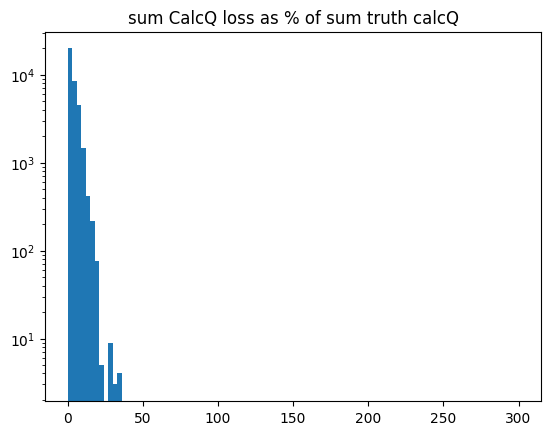

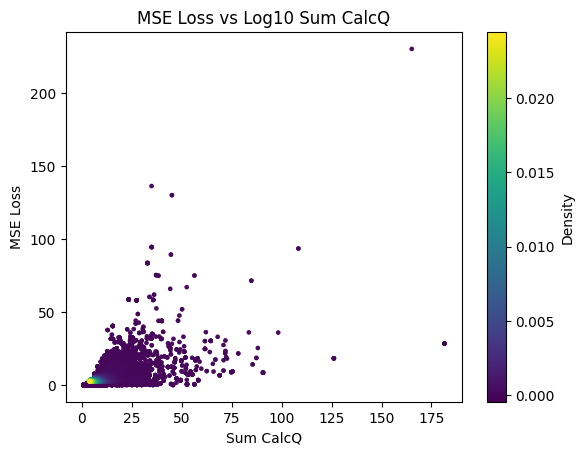

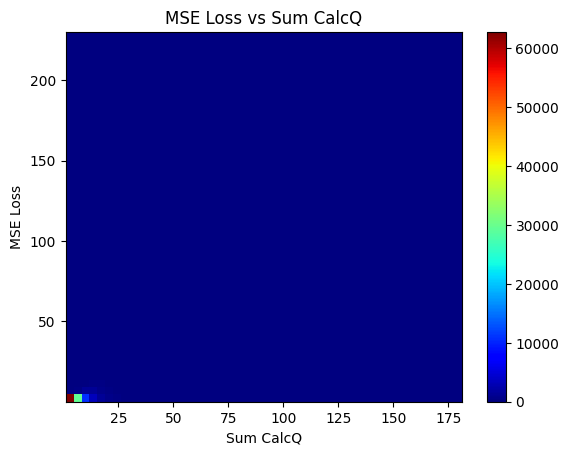

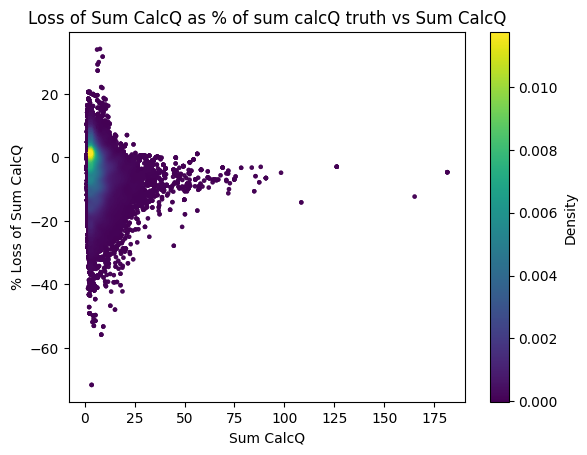

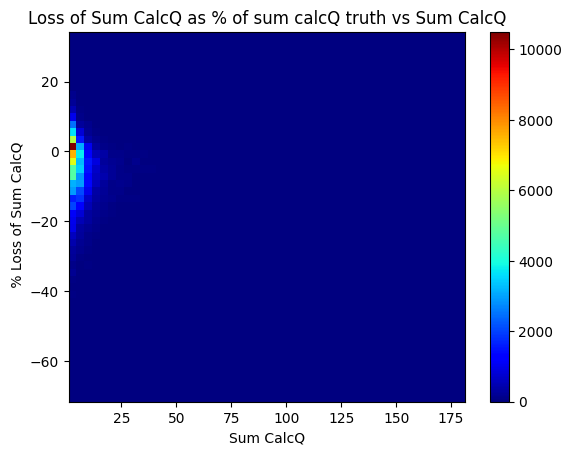

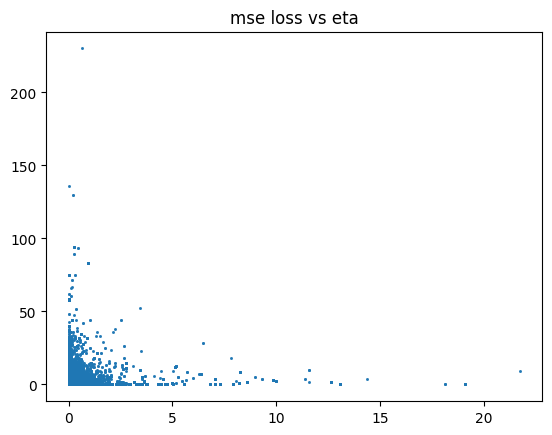

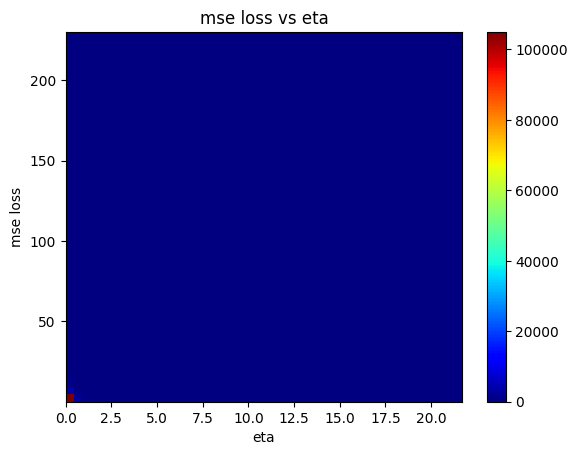

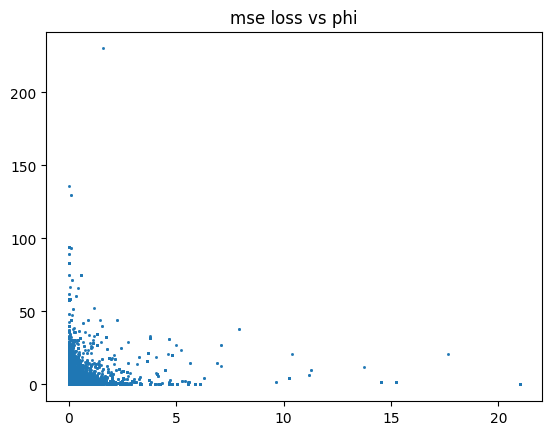

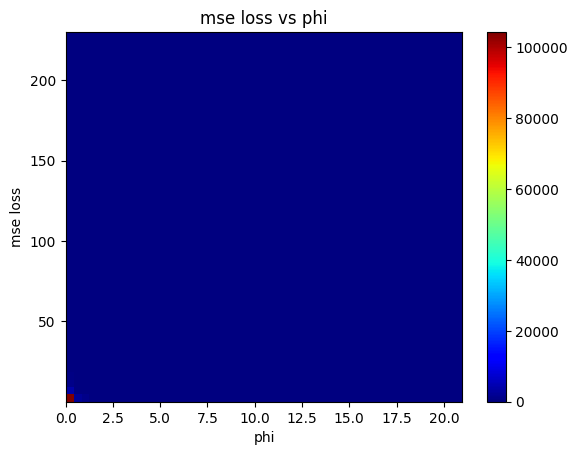

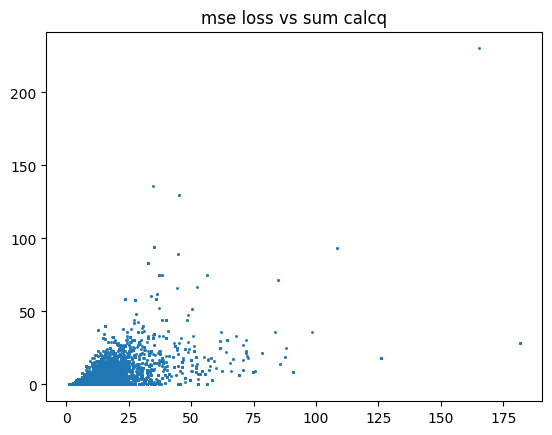

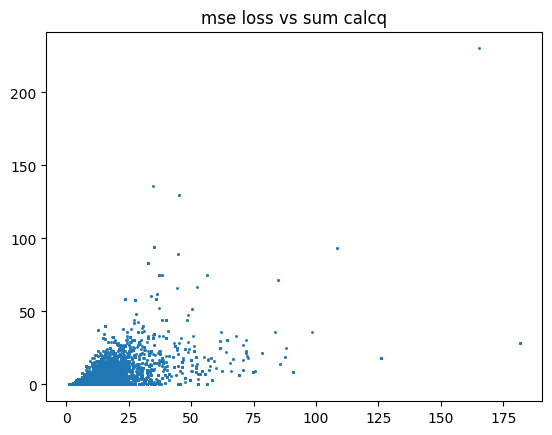

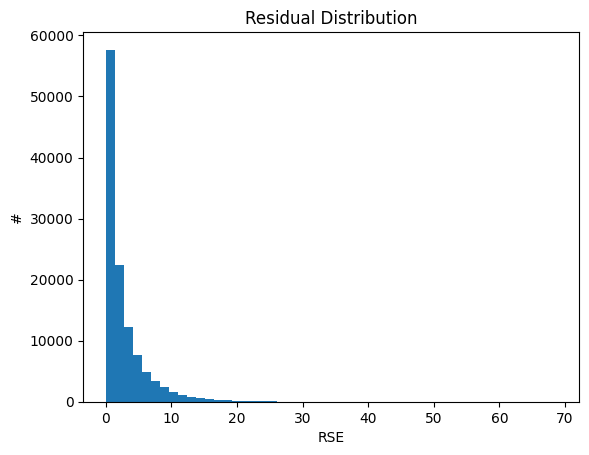

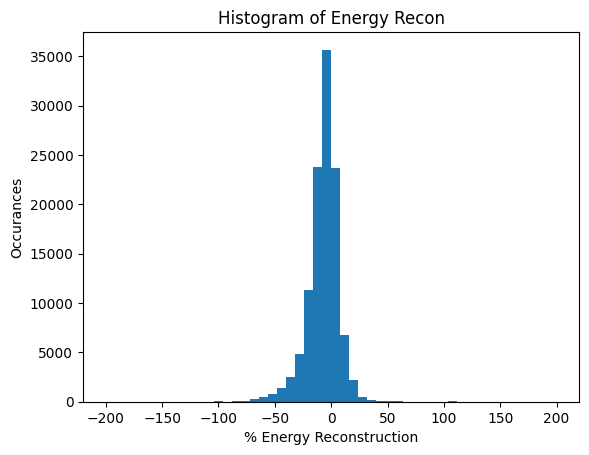

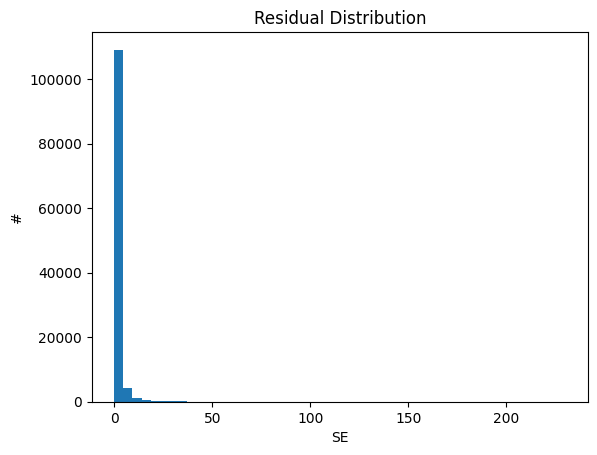

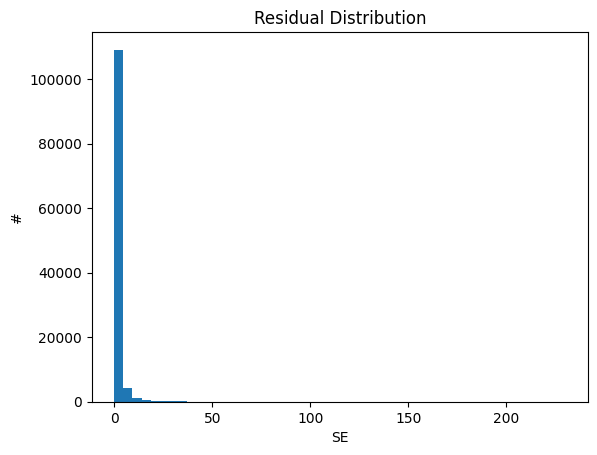

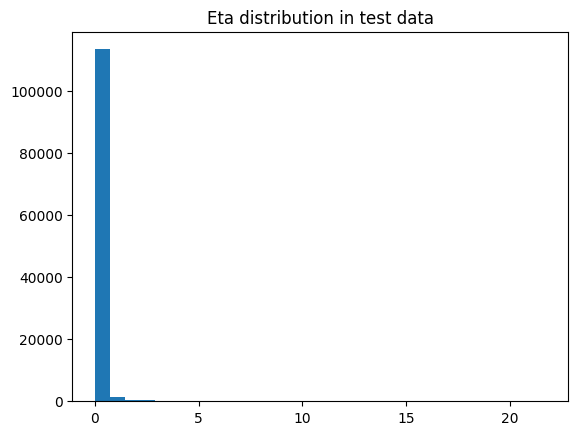

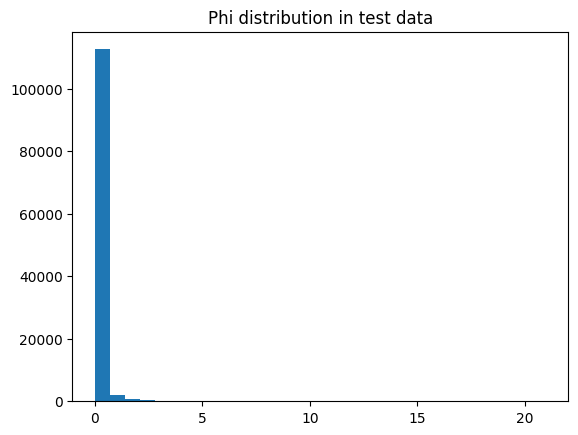

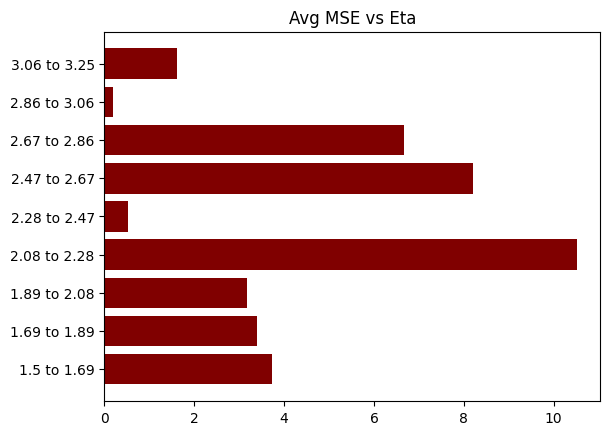

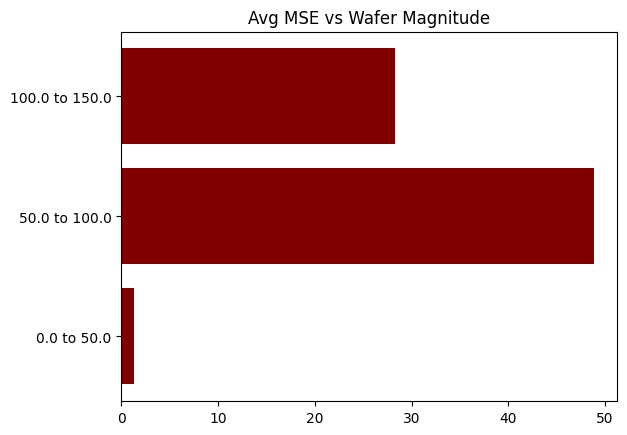

tensor([[1.3186e-01, 0.0000e+00, 5.0173e+00, 1.2416e-01, 1.0148e+00],
        [5.1617e-01, 0.0000e+00, 4.2627e+00, 1.7110e-01, 1.2355e+00],
        [0.0000e+00, 0.0000e+00, 1.2660e+01, 2.6597e-01, 1.5009e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 1.8589e+00, 7.4979e-03, 2.2020e-01],
        [0.0000e+00, 0.0000e+00, 1.4998e+00, 5.2847e-02, 4.9356e-01],
        [0.0000e+00, 0.0000e+00, 1.4188e+00, 1.2272e-02, 2.0078e-01]],
       grad_fn=<CatBackward0>)

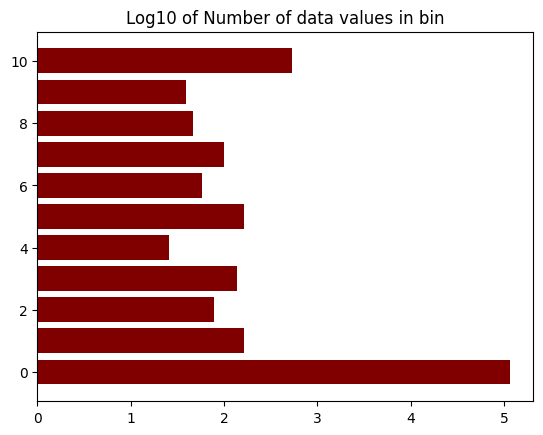

In [93]:
AE_Stats.gen_all_stats(test_pred.cpu(),data_1_test.cpu(),data_1_test.cpu())


In [4]:
from CondAE import *

In [5]:
# provide path to data
data_path = '/uscms/home/nswood/nobackup/Notebooks/AE_Dev/MIT_TTbar'

In [6]:
all_files = os.listdir(data_path)
dt_files = []
for f in all_files:
    if f[0:7] == 'dt_norm' and (f[-3:] != 'low' and f[-4:] !='high'):
        dt_files.append(f)
      

In [9]:
train_condAEs(data_path,
              dt_files,
               model_params = [],
              override = True,
              loss = combo_loss, 
              path_1 = 'models/combo_loss_low_layer',
              path_2 = 'models/combo_loss_high_layer',
              path_3 = 'models/combo_loss_all',
             dir_label ='condAE_mean_split_450_250_combo_loss',
             epochs= 200,
             tele = False,
             batch = 200, 
             lr = 8.5e-9)

TRAINING MODEL dt_norm_3_36: 1/82
LOW
TRAINING INFO:
Total Dataset Size: 26476
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.125, Test 0.131
MSE NON-NORMALIZED: Train MSE 1.673, Test MSE 1.674
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.122, Test 0.128
MSE NON-NORMALIZED: Train MSE 1.635, Test MSE 1.637
Epoch 50, lr 8.5e-09
Epoch 50: Train 0.120, Test 0.126
MSE NON-NORMALIZED: Train MSE 1.608, Test MSE 1.610
Epoch 75, lr 8.5e-09
Epoch 75: Train 0.118, Test 0.124
MSE NON-NORMALIZED: Train MSE 1.587, Test MSE 1.589
Epoch 100, lr 8.5e-09
Epoch 100: Train 0.117, Test 0.122
MSE NON-NORMALIZED: Train MSE 1.570, Test MSE 1.572
Epoch 125, lr 8.5e-09
Epoch 125: Train 0.116, Test 0.121
MSE NON-NORMALIZED: Train MSE 1.556, Test MSE 1.558
Epoch 150, lr 8.5e-09
Epoch 150: Train 0.115, Test 0.120
MSE NON-NORMALIZED: Train MSE 1.544, Test MSE 1.546
Epoch 175, lr 8.5e-09
Epoch 175: Train 0.114, Test 0.119
MSE NON-NORMALIZED: Train MSE 1.534, Test MSE 1.536
HIGH
TRAINING INFO:
Total Dataset Size: 26476
Epoch 0, lr 8

Epoch 175, lr 8.5e-09
Epoch 175: Train 0.086, Test 0.094
MSE NON-NORMALIZED: Train MSE 1.217, Test MSE 1.217
HIGH
TRAINING INFO:
Total Dataset Size: 40899
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.094, Test 0.094
MSE NON-NORMALIZED: Train MSE 1.218, Test MSE 1.217
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.094, Test 0.094
MSE NON-NORMALIZED: Train MSE 1.218, Test MSE 1.217
Epoch 50, lr 8.5e-09
Epoch 50: Train 0.094, Test 0.094
MSE NON-NORMALIZED: Train MSE 1.218, Test MSE 1.218
Epoch 75, lr 8.5e-09
Epoch 75: Train 0.094, Test 0.094
MSE NON-NORMALIZED: Train MSE 1.219, Test MSE 1.218
Epoch 100, lr 8.5e-09
Epoch 100: Train 0.095, Test 0.094
MSE NON-NORMALIZED: Train MSE 1.220, Test MSE 1.219
Epoch 125, lr 8.5e-09
Epoch 125: Train 0.095, Test 0.094
MSE NON-NORMALIZED: Train MSE 1.220, Test MSE 1.220
Epoch 150, lr 8.5e-09
Epoch 150: Train 0.095, Test 0.094
MSE NON-NORMALIZED: Train MSE 1.221, Test MSE 1.220
Epoch 175, lr 8.5e-09
Epoch 175: Train 0.095, Test 0.094
MSE NON-NORMALIZED: Train MSE 1.222

Epoch 150, lr 8.5e-09
Epoch 150: Train 0.150, Test 0.149
MSE NON-NORMALIZED: Train MSE 1.959, Test MSE 1.962
Epoch 175, lr 8.5e-09
Epoch 175: Train 0.150, Test 0.149
MSE NON-NORMALIZED: Train MSE 1.959, Test MSE 1.962
TRAINING MODEL dt_norm_3_34: 10/82
LOW
TRAINING INFO:
Total Dataset Size: 49695
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.115, Test 0.109
MSE NON-NORMALIZED: Train MSE 1.401, Test MSE 1.400
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.113, Test 0.107
MSE NON-NORMALIZED: Train MSE 1.377, Test MSE 1.376
Epoch 50, lr 8.5e-09
Epoch 50: Train 0.112, Test 0.105
MSE NON-NORMALIZED: Train MSE 1.364, Test MSE 1.364
Epoch 75, lr 8.5e-09
Epoch 75: Train 0.111, Test 0.105
MSE NON-NORMALIZED: Train MSE 1.357, Test MSE 1.357
Epoch 100, lr 8.5e-09
Epoch 100: Train 0.110, Test 0.104
MSE NON-NORMALIZED: Train MSE 1.352, Test MSE 1.352
Epoch 125, lr 8.5e-09
Epoch 125: Train 0.110, Test 0.104
MSE NON-NORMALIZED: Train MSE 1.350, Test MSE 1.349
Epoch 150, lr 8.5e-09
Epoch 150: Train 0.110, Test 0.104
M

Epoch 100, lr 8.5e-09
Epoch 100: Train 7.597, Test 7.746
MSE NON-NORMALIZED: Train MSE 138.207, Test MSE 138.200
Epoch 125, lr 8.5e-09
Epoch 125: Train 7.605, Test 7.752
MSE NON-NORMALIZED: Train MSE 137.218, Test MSE 137.210
Epoch 150, lr 8.5e-09
Epoch 150: Train 7.609, Test 7.756
MSE NON-NORMALIZED: Train MSE 136.369, Test MSE 136.360
Epoch 175, lr 8.5e-09
Epoch 175: Train 7.612, Test 7.757
MSE NON-NORMALIZED: Train MSE 135.590, Test MSE 135.579
HIGH
TRAINING INFO:
Total Dataset Size: 437054
Epoch 0, lr 8.5e-09
Epoch 0: Train 7.445, Test 7.757
MSE NON-NORMALIZED: Train MSE 134.854, Test MSE 134.841
Epoch 25, lr 8.5e-09
Epoch 25: Train 7.445, Test 7.756
MSE NON-NORMALIZED: Train MSE 134.160, Test MSE 134.145
Epoch 50, lr 8.5e-09
Epoch 50: Train 7.445, Test 7.755
MSE NON-NORMALIZED: Train MSE 133.508, Test MSE 133.491
Epoch 75, lr 8.5e-09
Epoch 75: Train 7.444, Test 7.753
MSE NON-NORMALIZED: Train MSE 132.892, Test MSE 132.873
Epoch 100, lr 8.5e-09
Epoch 100: Train 7.444, Test 7.752
MS

Epoch 50, lr 8.5e-09
Epoch 50: Train 3.362, Test 3.334
MSE NON-NORMALIZED: Train MSE 48.271, Test MSE 48.196
Epoch 75, lr 8.5e-09
Epoch 75: Train 3.356, Test 3.327
MSE NON-NORMALIZED: Train MSE 48.161, Test MSE 48.086
Epoch 100, lr 8.5e-09
Epoch 100: Train 3.350, Test 3.320
MSE NON-NORMALIZED: Train MSE 48.056, Test MSE 47.981
Epoch 125, lr 8.5e-09
Epoch 125: Train 3.344, Test 3.314
MSE NON-NORMALIZED: Train MSE 47.957, Test MSE 47.881
Epoch 150, lr 8.5e-09
Epoch 150: Train 3.338, Test 3.308
MSE NON-NORMALIZED: Train MSE 47.862, Test MSE 47.786
Epoch 175, lr 8.5e-09
Epoch 175: Train 3.333, Test 3.303
MSE NON-NORMALIZED: Train MSE 47.770, Test MSE 47.693
TRAINING MODEL dt_norm_1_15: 19/82
LOW
TRAINING INFO:
Total Dataset Size: 204833
Epoch 0, lr 8.5e-09
Epoch 0: Train 2.962, Test 3.023
MSE NON-NORMALIZED: Train MSE 42.691, Test MSE 42.695
Epoch 25, lr 8.5e-09
Epoch 25: Train 2.903, Test 2.970
MSE NON-NORMALIZED: Train MSE 42.222, Test MSE 42.235
Epoch 50, lr 8.5e-09
Epoch 50: Train 2.86

TRAINING MODEL dt_norm_1_23: 23/82
LOW
TRAINING INFO:
Total Dataset Size: 117452
Epoch 0, lr 8.5e-09
Epoch 0: Train 1.168, Test 1.346
MSE NON-NORMALIZED: Train MSE 18.219, Test MSE 18.211
Epoch 25, lr 8.5e-09
Epoch 25: Train 1.141, Test 1.317
MSE NON-NORMALIZED: Train MSE 17.955, Test MSE 17.951
Epoch 50, lr 8.5e-09
Epoch 50: Train 1.124, Test 1.299
MSE NON-NORMALIZED: Train MSE 17.837, Test MSE 17.834
Epoch 75, lr 8.5e-09
Epoch 75: Train 1.115, Test 1.289
MSE NON-NORMALIZED: Train MSE 17.769, Test MSE 17.766
Epoch 100, lr 8.5e-09
Epoch 100: Train 1.109, Test 1.283
MSE NON-NORMALIZED: Train MSE 17.713, Test MSE 17.710
Epoch 125, lr 8.5e-09
Epoch 125: Train 1.106, Test 1.279
MSE NON-NORMALIZED: Train MSE 17.663, Test MSE 17.660
Epoch 150, lr 8.5e-09
Epoch 150: Train 1.103, Test 1.275
MSE NON-NORMALIZED: Train MSE 17.618, Test MSE 17.615
Epoch 175, lr 8.5e-09
Epoch 175: Train 1.100, Test 1.272
MSE NON-NORMALIZED: Train MSE 17.577, Test MSE 17.573
HIGH
TRAINING INFO:
Total Dataset Size: 1

Epoch 150, lr 8.5e-09
Epoch 150: Train 0.277, Test 0.264
MSE NON-NORMALIZED: Train MSE 3.506, Test MSE 3.505
Epoch 175, lr 8.5e-09
Epoch 175: Train 0.277, Test 0.264
MSE NON-NORMALIZED: Train MSE 3.503, Test MSE 3.501
HIGH
TRAINING INFO:
Total Dataset Size: 132654
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.285, Test 0.264
MSE NON-NORMALIZED: Train MSE 3.500, Test MSE 3.499
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.285, Test 0.263
MSE NON-NORMALIZED: Train MSE 3.498, Test MSE 3.496
Epoch 50, lr 8.5e-09
Epoch 50: Train 0.284, Test 0.263
MSE NON-NORMALIZED: Train MSE 3.496, Test MSE 3.495
Epoch 75, lr 8.5e-09
Epoch 75: Train 0.284, Test 0.263
MSE NON-NORMALIZED: Train MSE 3.495, Test MSE 3.493
Epoch 100, lr 8.5e-09
Epoch 100: Train 0.284, Test 0.263
MSE NON-NORMALIZED: Train MSE 3.494, Test MSE 3.492
Epoch 125, lr 8.5e-09
Epoch 125: Train 0.284, Test 0.263
MSE NON-NORMALIZED: Train MSE 3.493, Test MSE 3.492
Epoch 150, lr 8.5e-09
Epoch 150: Train 0.284, Test 0.263
MSE NON-NORMALIZED: Train MSE 3.49

Epoch 125, lr 8.5e-09
Epoch 125: Train 2.595, Test 2.642
MSE NON-NORMALIZED: Train MSE 49.821, Test MSE 49.768
Epoch 150, lr 8.5e-09
Epoch 150: Train 2.594, Test 2.642
MSE NON-NORMALIZED: Train MSE 49.751, Test MSE 49.698
Epoch 175, lr 8.5e-09
Epoch 175: Train 2.593, Test 2.641
MSE NON-NORMALIZED: Train MSE 49.682, Test MSE 49.628
TRAINING MODEL dt_norm_2_3: 32/82
LOW
TRAINING INFO:
Total Dataset Size: 62948
Epoch 0, lr 8.5e-09
Epoch 0: Train 4.094, Test 4.101
MSE NON-NORMALIZED: Train MSE 67.520, Test MSE 67.489
Epoch 25, lr 8.5e-09
Epoch 25: Train 4.099, Test 4.104
MSE NON-NORMALIZED: Train MSE 66.405, Test MSE 66.379
Epoch 50, lr 8.5e-09
Epoch 50: Train 4.104, Test 4.109
MSE NON-NORMALIZED: Train MSE 65.508, Test MSE 65.485
Epoch 75, lr 8.5e-09
Epoch 75: Train 4.110, Test 4.114
MSE NON-NORMALIZED: Train MSE 64.794, Test MSE 64.775
Epoch 100, lr 8.5e-09
Epoch 100: Train 4.115, Test 4.117
MSE NON-NORMALIZED: Train MSE 64.229, Test MSE 64.212
Epoch 125, lr 8.5e-09
Epoch 125: Train 4.11

Epoch 75, lr 8.5e-09
Epoch 75: Train 2.045, Test 1.976
MSE NON-NORMALIZED: Train MSE 29.971, Test MSE 29.974
Epoch 100, lr 8.5e-09
Epoch 100: Train 2.042, Test 1.972
MSE NON-NORMALIZED: Train MSE 29.715, Test MSE 29.719
Epoch 125, lr 8.5e-09
Epoch 125: Train 2.039, Test 1.968
MSE NON-NORMALIZED: Train MSE 29.498, Test MSE 29.502
Epoch 150, lr 8.5e-09
Epoch 150: Train 2.035, Test 1.963
MSE NON-NORMALIZED: Train MSE 29.301, Test MSE 29.305
Epoch 175, lr 8.5e-09
Epoch 175: Train 2.031, Test 1.958
MSE NON-NORMALIZED: Train MSE 29.118, Test MSE 29.121
HIGH
TRAINING INFO:
Total Dataset Size: 64943
Epoch 0, lr 8.5e-09
Epoch 0: Train 1.943, Test 1.953
MSE NON-NORMALIZED: Train MSE 28.952, Test MSE 28.950
Epoch 25, lr 8.5e-09
Epoch 25: Train 1.940, Test 1.950
MSE NON-NORMALIZED: Train MSE 28.854, Test MSE 28.852
Epoch 50, lr 8.5e-09
Epoch 50: Train 1.936, Test 1.946
MSE NON-NORMALIZED: Train MSE 28.761, Test MSE 28.758
Epoch 75, lr 8.5e-09
Epoch 75: Train 1.933, Test 1.943
MSE NON-NORMALIZED: T

Epoch 25, lr 8.5e-09
Epoch 25: Train 1.322, Test 1.181
MSE NON-NORMALIZED: Train MSE 16.206, Test MSE 16.174
Epoch 50, lr 8.5e-09
Epoch 50: Train 1.319, Test 1.179
MSE NON-NORMALIZED: Train MSE 16.175, Test MSE 16.143
Epoch 75, lr 8.5e-09
Epoch 75: Train 1.316, Test 1.176
MSE NON-NORMALIZED: Train MSE 16.145, Test MSE 16.112
Epoch 100, lr 8.5e-09
Epoch 100: Train 1.313, Test 1.173
MSE NON-NORMALIZED: Train MSE 16.116, Test MSE 16.083
Epoch 125, lr 8.5e-09
Epoch 125: Train 1.310, Test 1.171
MSE NON-NORMALIZED: Train MSE 16.088, Test MSE 16.054
Epoch 150, lr 8.5e-09
Epoch 150: Train 1.308, Test 1.169
MSE NON-NORMALIZED: Train MSE 16.060, Test MSE 16.027
Epoch 175, lr 8.5e-09
Epoch 175: Train 1.305, Test 1.166
MSE NON-NORMALIZED: Train MSE 16.033, Test MSE 15.999
TRAINING MODEL dt_norm_2_21: 41/82
LOW
TRAINING INFO:
Total Dataset Size: 28864
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.863, Test 0.853
MSE NON-NORMALIZED: Train MSE 11.469, Test MSE 11.448
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.849

TRAINING MODEL dt_norm_2_29: 45/82
LOW
TRAINING INFO:
Total Dataset Size: 24880
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.163, Test 0.136
MSE NON-NORMALIZED: Train MSE 1.737, Test MSE 1.734
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.161, Test 0.134
MSE NON-NORMALIZED: Train MSE 1.717, Test MSE 1.714
Epoch 50, lr 8.5e-09
Epoch 50: Train 0.160, Test 0.132
MSE NON-NORMALIZED: Train MSE 1.703, Test MSE 1.700
Epoch 75, lr 8.5e-09
Epoch 75: Train 0.158, Test 0.131
MSE NON-NORMALIZED: Train MSE 1.692, Test MSE 1.689
Epoch 100, lr 8.5e-09
Epoch 100: Train 0.158, Test 0.130
MSE NON-NORMALIZED: Train MSE 1.683, Test MSE 1.680
Epoch 125, lr 8.5e-09
Epoch 125: Train 0.157, Test 0.130
MSE NON-NORMALIZED: Train MSE 1.676, Test MSE 1.673
Epoch 150, lr 8.5e-09
Epoch 150: Train 0.156, Test 0.129
MSE NON-NORMALIZED: Train MSE 1.669, Test MSE 1.666
Epoch 175, lr 8.5e-09
Epoch 175: Train 0.156, Test 0.129
MSE NON-NORMALIZED: Train MSE 1.664, Test MSE 1.661
HIGH
TRAINING INFO:
Total Dataset Size: 24880
Epoch 0, lr 

Epoch 175, lr 8.5e-09
Epoch 175: Train 0.119, Test 0.116
MSE NON-NORMALIZED: Train MSE 1.508, Test MSE 1.506
HIGH
TRAINING INFO:
Total Dataset Size: 54900
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.116, Test 0.116
MSE NON-NORMALIZED: Train MSE 1.507, Test MSE 1.505
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.116, Test 0.116
MSE NON-NORMALIZED: Train MSE 1.507, Test MSE 1.505
Epoch 50, lr 8.5e-09
Epoch 50: Train 0.116, Test 0.116
MSE NON-NORMALIZED: Train MSE 1.507, Test MSE 1.504
Epoch 75, lr 8.5e-09
Epoch 75: Train 0.116, Test 0.116
MSE NON-NORMALIZED: Train MSE 1.507, Test MSE 1.504
Epoch 100, lr 8.5e-09
Epoch 100: Train 0.116, Test 0.116
MSE NON-NORMALIZED: Train MSE 1.507, Test MSE 1.504
Epoch 125, lr 8.5e-09
Epoch 125: Train 0.116, Test 0.116
MSE NON-NORMALIZED: Train MSE 1.507, Test MSE 1.505
Epoch 150, lr 8.5e-09
Epoch 150: Train 0.116, Test 0.116
MSE NON-NORMALIZED: Train MSE 1.507, Test MSE 1.505
Epoch 175, lr 8.5e-09
Epoch 175: Train 0.116, Test 0.116
MSE NON-NORMALIZED: Train MSE 1.508

Epoch 150, lr 8.5e-09
Epoch 150: Train 0.099, Test 0.074
MSE NON-NORMALIZED: Train MSE 0.970, Test MSE 0.952
Epoch 175, lr 8.5e-09
Epoch 175: Train 0.099, Test 0.074
MSE NON-NORMALIZED: Train MSE 0.968, Test MSE 0.950
TRAINING MODEL dt_norm_2_39: 54/82
LOW
TRAINING INFO:
Total Dataset Size: 5616
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.089, Test 0.077
MSE NON-NORMALIZED: Train MSE 0.996, Test MSE 0.994
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.088, Test 0.077
MSE NON-NORMALIZED: Train MSE 0.987, Test MSE 0.984
Epoch 50, lr 8.5e-09
Epoch 50: Train 0.087, Test 0.076
MSE NON-NORMALIZED: Train MSE 0.978, Test MSE 0.976
Epoch 75, lr 8.5e-09
Epoch 75: Train 0.086, Test 0.075
MSE NON-NORMALIZED: Train MSE 0.970, Test MSE 0.968
Epoch 100, lr 8.5e-09
Epoch 100: Train 0.086, Test 0.075
MSE NON-NORMALIZED: Train MSE 0.963, Test MSE 0.960
Epoch 125, lr 8.5e-09
Epoch 125: Train 0.085, Test 0.074
MSE NON-NORMALIZED: Train MSE 0.956, Test MSE 0.953
Epoch 150, lr 8.5e-09
Epoch 150: Train 0.085, Test 0.074
MS

Epoch 125, lr 8.5e-09
Epoch 125: Train 0.043, Test 0.043
MSE NON-NORMALIZED: Train MSE 0.548, Test MSE 0.547
Epoch 150, lr 8.5e-09
Epoch 150: Train 0.043, Test 0.043
MSE NON-NORMALIZED: Train MSE 0.545, Test MSE 0.545
Epoch 175, lr 8.5e-09
Epoch 175: Train 0.043, Test 0.043
MSE NON-NORMALIZED: Train MSE 0.543, Test MSE 0.543
HIGH
TRAINING INFO:
Total Dataset Size: 3203
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.035, Test 0.043
MSE NON-NORMALIZED: Train MSE 0.521, Test MSE 0.541
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.035, Test 0.043
MSE NON-NORMALIZED: Train MSE 0.520, Test MSE 0.540
Epoch 50, lr 8.5e-09
Epoch 50: Train 0.035, Test 0.043
MSE NON-NORMALIZED: Train MSE 0.520, Test MSE 0.539
Epoch 75, lr 8.5e-09
Epoch 75: Train 0.035, Test 0.043
MSE NON-NORMALIZED: Train MSE 0.519, Test MSE 0.539
Epoch 100, lr 8.5e-09
Epoch 100: Train 0.034, Test 0.042
MSE NON-NORMALIZED: Train MSE 0.518, Test MSE 0.538
Epoch 125, lr 8.5e-09
Epoch 125: Train 0.034, Test 0.042
MSE NON-NORMALIZED: Train MSE 0.518,

Epoch 100, lr 8.5e-09
Epoch 100: Train 3.136, Test 3.119
MSE NON-NORMALIZED: Train MSE 46.884, Test MSE 46.869
Epoch 125, lr 8.5e-09
Epoch 125: Train 3.134, Test 3.116
MSE NON-NORMALIZED: Train MSE 46.755, Test MSE 46.738
Epoch 150, lr 8.5e-09
Epoch 150: Train 3.131, Test 3.112
MSE NON-NORMALIZED: Train MSE 46.630, Test MSE 46.612
Epoch 175, lr 8.5e-09
Epoch 175: Train 3.128, Test 3.108
MSE NON-NORMALIZED: Train MSE 46.509, Test MSE 46.490
TRAINING MODEL dt_norm_3_5: 63/82
LOW
TRAINING INFO:
Total Dataset Size: 160880
Epoch 0, lr 8.5e-09
Epoch 0: Train 3.136, Test 2.982
MSE NON-NORMALIZED: Train MSE 50.265, Test MSE 50.171
Epoch 25, lr 8.5e-09
Epoch 25: Train 3.138, Test 2.985
MSE NON-NORMALIZED: Train MSE 49.488, Test MSE 49.395
Epoch 50, lr 8.5e-09
Epoch 50: Train 3.141, Test 2.988
MSE NON-NORMALIZED: Train MSE 48.843, Test MSE 48.748
Epoch 75, lr 8.5e-09
Epoch 75: Train 3.144, Test 2.991
MSE NON-NORMALIZED: Train MSE 48.328, Test MSE 48.233
Epoch 100, lr 8.5e-09
Epoch 100: Train 3.1

Epoch 50, lr 8.5e-09
Epoch 50: Train 1.211, Test 1.240
MSE NON-NORMALIZED: Train MSE 16.863, Test MSE 16.813
Epoch 75, lr 8.5e-09
Epoch 75: Train 1.200, Test 1.229
MSE NON-NORMALIZED: Train MSE 16.737, Test MSE 16.686
Epoch 100, lr 8.5e-09
Epoch 100: Train 1.191, Test 1.220
MSE NON-NORMALIZED: Train MSE 16.629, Test MSE 16.579
Epoch 125, lr 8.5e-09
Epoch 125: Train 1.183, Test 1.212
MSE NON-NORMALIZED: Train MSE 16.536, Test MSE 16.486
Epoch 150, lr 8.5e-09
Epoch 150: Train 1.176, Test 1.205
MSE NON-NORMALIZED: Train MSE 16.453, Test MSE 16.402
Epoch 175, lr 8.5e-09
Epoch 175: Train 1.170, Test 1.199
MSE NON-NORMALIZED: Train MSE 16.376, Test MSE 16.324
HIGH
TRAINING INFO:
Total Dataset Size: 66977
Epoch 0, lr 8.5e-09
Epoch 0: Train 1.289, Test 1.194
MSE NON-NORMALIZED: Train MSE 16.353, Test MSE 16.256
Epoch 25, lr 8.5e-09
Epoch 25: Train 1.287, Test 1.191
MSE NON-NORMALIZED: Train MSE 16.318, Test MSE 16.221
Epoch 50, lr 8.5e-09
Epoch 50: Train 1.285, Test 1.188
MSE NON-NORMALIZED: T

Epoch 0, lr 8.5e-09
Epoch 0: Train 0.810, Test 0.745
MSE NON-NORMALIZED: Train MSE 10.049, Test MSE 10.029
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.807, Test 0.743
MSE NON-NORMALIZED: Train MSE 10.021, Test MSE 10.002
Epoch 50, lr 8.5e-09
Epoch 50: Train 0.805, Test 0.741
MSE NON-NORMALIZED: Train MSE 9.995, Test MSE 9.975
Epoch 75, lr 8.5e-09
Epoch 75: Train 0.803, Test 0.739
MSE NON-NORMALIZED: Train MSE 9.969, Test MSE 9.949
Epoch 100, lr 8.5e-09
Epoch 100: Train 0.801, Test 0.737
MSE NON-NORMALIZED: Train MSE 9.944, Test MSE 9.923
Epoch 125, lr 8.5e-09
Epoch 125: Train 0.798, Test 0.735
MSE NON-NORMALIZED: Train MSE 9.919, Test MSE 9.898
Epoch 150, lr 8.5e-09
Epoch 150: Train 0.796, Test 0.733
MSE NON-NORMALIZED: Train MSE 9.895, Test MSE 9.874
Epoch 175, lr 8.5e-09
Epoch 175: Train 0.794, Test 0.731
MSE NON-NORMALIZED: Train MSE 9.871, Test MSE 9.850
TRAINING MODEL dt_norm_3_23: 72/82
LOW
TRAINING INFO:
Total Dataset Size: 34893
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.669, Test 0.772
M

Epoch 175, lr 8.5e-09
Epoch 175: Train 0.042, Test 0.038
MSE NON-NORMALIZED: Train MSE 0.496, Test MSE 0.494
TRAINING MODEL dt_norm_3_41: 76/82
LOW
TRAINING INFO:
Total Dataset Size: 18443
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.029, Test 0.027
MSE NON-NORMALIZED: Train MSE 0.346, Test MSE 0.346
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.029, Test 0.027
MSE NON-NORMALIZED: Train MSE 0.340, Test MSE 0.340
Epoch 50, lr 8.5e-09
Epoch 50: Train 0.028, Test 0.026
MSE NON-NORMALIZED: Train MSE 0.336, Test MSE 0.336
Epoch 75, lr 8.5e-09
Epoch 75: Train 0.028, Test 0.026
MSE NON-NORMALIZED: Train MSE 0.333, Test MSE 0.333
Epoch 100, lr 8.5e-09
Epoch 100: Train 0.028, Test 0.026
MSE NON-NORMALIZED: Train MSE 0.330, Test MSE 0.330
Epoch 125, lr 8.5e-09
Epoch 125: Train 0.028, Test 0.026
MSE NON-NORMALIZED: Train MSE 0.328, Test MSE 0.328
Epoch 150, lr 8.5e-09
Epoch 150: Train 0.027, Test 0.026
MSE NON-NORMALIZED: Train MSE 0.326, Test MSE 0.326
Epoch 175, lr 8.5e-09
Epoch 175: Train 0.027, Test 0.025
M

Epoch 150, lr 8.5e-09
Epoch 150: Train 0.040, Test 0.034
MSE NON-NORMALIZED: Train MSE 0.439, Test MSE 0.438
Epoch 175, lr 8.5e-09
Epoch 175: Train 0.040, Test 0.034
MSE NON-NORMALIZED: Train MSE 0.436, Test MSE 0.434
HIGH
TRAINING INFO:
Total Dataset Size: 13626
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.038, Test 0.034
MSE NON-NORMALIZED: Train MSE 0.433, Test MSE 0.432
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.038, Test 0.034
MSE NON-NORMALIZED: Train MSE 0.432, Test MSE 0.431
Epoch 50, lr 8.5e-09
Epoch 50: Train 0.037, Test 0.034
MSE NON-NORMALIZED: Train MSE 0.430, Test MSE 0.430
Epoch 75, lr 8.5e-09
Epoch 75: Train 0.037, Test 0.034
MSE NON-NORMALIZED: Train MSE 0.429, Test MSE 0.428
Epoch 100, lr 8.5e-09
Epoch 100: Train 0.037, Test 0.033
MSE NON-NORMALIZED: Train MSE 0.428, Test MSE 0.427
Epoch 125, lr 8.5e-09
Epoch 125: Train 0.037, Test 0.033
MSE NON-NORMALIZED: Train MSE 0.427, Test MSE 0.426
Epoch 150, lr 8.5e-09
Epoch 150: Train 0.037, Test 0.033
MSE NON-NORMALIZED: Train MSE 0.426

In [ ]:
train_condAEs(data_path,
              dt_files,
               model_params = [],
              override = True,
              loss = new_loss, 
              path_1 = 'models/combo_loss_low_layer',
              path_2 = 'models/combo_loss_high_layer',
              path_3 = 'models/combo_loss_all',
             dir_label ='condAE_mean_split_450_250_new_loss',
             epochs= 200,
             tele = False,
             batch = 200, 
             lr = 8.5e-9)

TRAINING MODEL dt_norm_3_36: 1/82
LOW
TRAINING INFO:
Total Dataset Size: 26476
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.146, Test 0.131
MSE NON-NORMALIZED: Train MSE 1.978, Test MSE 1.979
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.143, Test 0.128
MSE NON-NORMALIZED: Train MSE 1.925, Test MSE 1.927
Epoch 50, lr 8.5e-09
Epoch 50: Train 0.140, Test 0.125
MSE NON-NORMALIZED: Train MSE 1.885, Test MSE 1.887
Epoch 75, lr 8.5e-09
Epoch 75: Train 0.138, Test 0.124
MSE NON-NORMALIZED: Train MSE 2.016, Test MSE 2.671
Epoch 100, lr 8.5e-09
Epoch 100: Train 0.137, Test 0.123
MSE NON-NORMALIZED: Train MSE 2.140, Test MSE 3.350
Epoch 125, lr 8.5e-09
Epoch 125: Train 0.137, Test 0.122
MSE NON-NORMALIZED: Train MSE 2.117, Test MSE 3.271
Epoch 150, lr 8.5e-09
Epoch 150: Train 0.136, Test 0.122
MSE NON-NORMALIZED: Train MSE 2.100, Test MSE 3.223
Epoch 175, lr 8.5e-09
Epoch 175: Train 0.135, Test 0.121
MSE NON-NORMALIZED: Train MSE 2.085, Test MSE 3.183
HIGH
TRAINING INFO:
Total Dataset Size: 26476
Epoch 0, lr 8

Epoch 175, lr 8.5e-09
Epoch 175: Train 0.100, Test 0.096
MSE NON-NORMALIZED: Train MSE 1.733, Test MSE 3.610
HIGH
TRAINING INFO:
Total Dataset Size: 40899
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.088, Test 0.096
MSE NON-NORMALIZED: Train MSE 1.403, Test MSE 1.404
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.087, Test 0.095
MSE NON-NORMALIZED: Train MSE 1.390, Test MSE 1.391
Epoch 50, lr 8.5e-09
Epoch 50: Train 0.087, Test 0.095
MSE NON-NORMALIZED: Train MSE 1.383, Test MSE 1.384
Epoch 75, lr 8.5e-09
Epoch 75: Train 0.087, Test 0.095
MSE NON-NORMALIZED: Train MSE 1.561, Test MSE 3.441
Epoch 100, lr 8.5e-09
Epoch 100: Train 0.088, Test 0.096
MSE NON-NORMALIZED: Train MSE 1.724, Test MSE 5.227
Epoch 125, lr 8.5e-09
Epoch 125: Train 0.088, Test 0.096
MSE NON-NORMALIZED: Train MSE 1.720, Test MSE 5.106
Epoch 150, lr 8.5e-09
Epoch 150: Train 0.088, Test 0.096
MSE NON-NORMALIZED: Train MSE 1.718, Test MSE 5.043
Epoch 175, lr 8.5e-09
Epoch 175: Train 0.089, Test 0.096
MSE NON-NORMALIZED: Train MSE 1.716

Epoch 150, lr 8.5e-09
Epoch 150: Train 0.152, Test 0.149
MSE NON-NORMALIZED: Train MSE 2.793, Test MSE 8.416
Epoch 175, lr 8.5e-09
Epoch 175: Train 0.152, Test 0.150
MSE NON-NORMALIZED: Train MSE 2.790, Test MSE 8.342
TRAINING MODEL dt_norm_3_34: 10/82
LOW
TRAINING INFO:
Total Dataset Size: 49695
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.114, Test 0.109
MSE NON-NORMALIZED: Train MSE 1.632, Test MSE 1.630
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.112, Test 0.106
MSE NON-NORMALIZED: Train MSE 1.592, Test MSE 1.591
Epoch 50, lr 8.5e-09
Epoch 50: Train 0.110, Test 0.105
MSE NON-NORMALIZED: Train MSE 1.570, Test MSE 1.569
Epoch 75, lr 8.5e-09
Epoch 75: Train 0.110, Test 0.104
MSE NON-NORMALIZED: Train MSE 1.776, Test MSE 3.557
Epoch 100, lr 8.5e-09
Epoch 100: Train 0.110, Test 0.105
MSE NON-NORMALIZED: Train MSE 1.960, Test MSE 5.216
Epoch 125, lr 8.5e-09
Epoch 125: Train 0.111, Test 0.105
MSE NON-NORMALIZED: Train MSE 1.948, Test MSE 5.074
Epoch 150, lr 8.5e-09
Epoch 150: Train 0.111, Test 0.105
M

Epoch 100, lr 8.5e-09
Epoch 100: Train 7.590, Test 7.667
MSE NON-NORMALIZED: Train MSE 200.403, Test MSE 432.278
Epoch 125, lr 8.5e-09
Epoch 125: Train 7.582, Test 7.659
MSE NON-NORMALIZED: Train MSE 200.092, Test MSE 427.662
Epoch 150, lr 8.5e-09
Epoch 150: Train 7.574, Test 7.651
MSE NON-NORMALIZED: Train MSE 199.811, Test MSE 424.056
Epoch 175, lr 8.5e-09
Epoch 175: Train 7.567, Test 7.643
MSE NON-NORMALIZED: Train MSE 199.552, Test MSE 421.220
HIGH
TRAINING INFO:
Total Dataset Size: 437054
Epoch 0, lr 8.5e-09
Epoch 0: Train 7.748, Test 7.636
MSE NON-NORMALIZED: Train MSE 194.322, Test MSE 194.309
Epoch 25, lr 8.5e-09
Epoch 25: Train 7.738, Test 7.626
MSE NON-NORMALIZED: Train MSE 194.055, Test MSE 194.040
Epoch 50, lr 8.5e-09
Epoch 50: Train 7.729, Test 7.616
MSE NON-NORMALIZED: Train MSE 193.814, Test MSE 193.796
Epoch 75, lr 8.5e-09
Epoch 75: Train 7.722, Test 7.608
MSE NON-NORMALIZED: Train MSE 196.183, Test MSE 309.798
Epoch 100, lr 8.5e-09
Epoch 100: Train 7.716, Test 7.602
MS

Epoch 25, lr 8.5e-09
Epoch 25: Train 3.214, Test 3.180
MSE NON-NORMALIZED: Train MSE 64.518, Test MSE 64.422
Epoch 50, lr 8.5e-09
Epoch 50: Train 3.197, Test 3.162
MSE NON-NORMALIZED: Train MSE 64.169, Test MSE 64.074
Epoch 75, lr 8.5e-09
Epoch 75: Train 3.185, Test 3.149
MSE NON-NORMALIZED: Train MSE 66.417, Test MSE 143.481
Epoch 100, lr 8.5e-09
Epoch 100: Train 3.179, Test 3.143
MSE NON-NORMALIZED: Train MSE 68.725, Test MSE 221.228
Epoch 125, lr 8.5e-09
Epoch 125: Train 3.175, Test 3.139
MSE NON-NORMALIZED: Train MSE 68.532, Test MSE 218.035
Epoch 150, lr 8.5e-09
Epoch 150: Train 3.171, Test 3.134
MSE NON-NORMALIZED: Train MSE 68.360, Test MSE 215.873
Epoch 175, lr 8.5e-09
Epoch 175: Train 3.165, Test 3.129
MSE NON-NORMALIZED: Train MSE 68.203, Test MSE 214.443
TRAINING MODEL dt_norm_1_15: 19/82
LOW
TRAINING INFO:
Total Dataset Size: 204833
Epoch 0, lr 8.5e-09
Epoch 0: Train 3.305, Test 3.023
MSE NON-NORMALIZED: Train MSE 60.299, Test MSE 60.300
Epoch 25, lr 8.5e-09
Epoch 25: Train

Epoch 175, lr 8.5e-09
Epoch 175: Train 1.555, Test 1.538
MSE NON-NORMALIZED: Train MSE 31.180, Test MSE 90.986
TRAINING MODEL dt_norm_1_23: 23/82
LOW
TRAINING INFO:
Total Dataset Size: 117452
Epoch 0, lr 8.5e-09
Epoch 0: Train 1.438, Test 1.346
MSE NON-NORMALIZED: Train MSE 23.961, Test MSE 23.945
Epoch 25, lr 8.5e-09
Epoch 25: Train 1.402, Test 1.312
MSE NON-NORMALIZED: Train MSE 23.351, Test MSE 23.340
Epoch 50, lr 8.5e-09
Epoch 50: Train 1.374, Test 1.286
MSE NON-NORMALIZED: Train MSE 22.890, Test MSE 22.880
Epoch 75, lr 8.5e-09
Epoch 75: Train 1.354, Test 1.269
MSE NON-NORMALIZED: Train MSE 23.692, Test MSE 45.707
Epoch 100, lr 8.5e-09
Epoch 100: Train 1.345, Test 1.261
MSE NON-NORMALIZED: Train MSE 24.733, Test MSE 70.186
Epoch 125, lr 8.5e-09
Epoch 125: Train 1.341, Test 1.257
MSE NON-NORMALIZED: Train MSE 24.657, Test MSE 69.833
Epoch 150, lr 8.5e-09
Epoch 150: Train 1.337, Test 1.254
MSE NON-NORMALIZED: Train MSE 24.588, Test MSE 69.731
Epoch 175, lr 8.5e-09
Epoch 175: Train 1.

Epoch 125, lr 8.5e-09
Epoch 125: Train 0.253, Test 0.273
MSE NON-NORMALIZED: Train MSE 4.855, Test MSE 20.913
Epoch 150, lr 8.5e-09
Epoch 150: Train 0.255, Test 0.275
MSE NON-NORMALIZED: Train MSE 4.835, Test MSE 19.801
Epoch 175, lr 8.5e-09
Epoch 175: Train 0.256, Test 0.276
MSE NON-NORMALIZED: Train MSE 4.823, Test MSE 19.270
HIGH
TRAINING INFO:
Total Dataset Size: 132654
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.265, Test 0.276
MSE NON-NORMALIZED: Train MSE 4.150, Test MSE 4.147
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.259, Test 0.270
MSE NON-NORMALIZED: Train MSE 4.054, Test MSE 4.051
Epoch 50, lr 8.5e-09
Epoch 50: Train 0.255, Test 0.266
MSE NON-NORMALIZED: Train MSE 3.993, Test MSE 3.991
Epoch 75, lr 8.5e-09
Epoch 75: Train 0.254, Test 0.265
MSE NON-NORMALIZED: Train MSE 4.450, Test MSE 14.425
Epoch 100, lr 8.5e-09
Epoch 100: Train 0.258, Test 0.269
MSE NON-NORMALIZED: Train MSE 4.839, Test MSE 21.876
Epoch 125, lr 8.5e-09
Epoch 125: Train 0.262, Test 0.273
MSE NON-NORMALIZED: Train MSE

Epoch 100, lr 8.5e-09
Epoch 100: Train 2.567, Test 2.611
MSE NON-NORMALIZED: Train MSE 66.129, Test MSE 77.051
Epoch 125, lr 8.5e-09
Epoch 125: Train 2.566, Test 2.609
MSE NON-NORMALIZED: Train MSE 66.079, Test MSE 76.986
Epoch 150, lr 8.5e-09
Epoch 150: Train 2.564, Test 2.608
MSE NON-NORMALIZED: Train MSE 66.031, Test MSE 76.924
Epoch 175, lr 8.5e-09
Epoch 175: Train 2.562, Test 2.606
MSE NON-NORMALIZED: Train MSE 65.983, Test MSE 76.865
TRAINING MODEL dt_norm_2_3: 32/82
LOW
TRAINING INFO:
Total Dataset Size: 62948
Epoch 0, lr 8.5e-09
Epoch 0: Train 4.038, Test 4.100
MSE NON-NORMALIZED: Train MSE 91.177, Test MSE 91.167
Epoch 25, lr 8.5e-09
Epoch 25: Train 4.019, Test 4.079
MSE NON-NORMALIZED: Train MSE 90.698, Test MSE 90.686
Epoch 50, lr 8.5e-09
Epoch 50: Train 4.002, Test 4.061
MSE NON-NORMALIZED: Train MSE 90.264, Test MSE 90.251
Epoch 75, lr 8.5e-09
Epoch 75: Train 3.987, Test 4.045
MSE NON-NORMALIZED: Train MSE 92.281, Test MSE 119.751
Epoch 100, lr 8.5e-09
Epoch 100: Train 3.9

Epoch 25, lr 8.5e-09
Epoch 25: Train 1.802, Test 1.974
MSE NON-NORMALIZED: Train MSE 41.185, Test MSE 41.196
Epoch 50, lr 8.5e-09
Epoch 50: Train 1.792, Test 1.962
MSE NON-NORMALIZED: Train MSE 40.897, Test MSE 40.907
Epoch 75, lr 8.5e-09
Epoch 75: Train 1.784, Test 1.951
MSE NON-NORMALIZED: Train MSE 42.302, Test MSE 62.069
Epoch 100, lr 8.5e-09
Epoch 100: Train 1.776, Test 1.941
MSE NON-NORMALIZED: Train MSE 43.696, Test MSE 82.703
Epoch 125, lr 8.5e-09
Epoch 125: Train 1.770, Test 1.932
MSE NON-NORMALIZED: Train MSE 43.437, Test MSE 81.836
Epoch 150, lr 8.5e-09
Epoch 150: Train 1.764, Test 1.924
MSE NON-NORMALIZED: Train MSE 43.196, Test MSE 81.085
Epoch 175, lr 8.5e-09
Epoch 175: Train 1.757, Test 1.915
MSE NON-NORMALIZED: Train MSE 42.970, Test MSE 80.418
HIGH
TRAINING INFO:
Total Dataset Size: 64943
Epoch 0, lr 8.5e-09
Epoch 0: Train 1.660, Test 1.907
MSE NON-NORMALIZED: Train MSE 39.611, Test MSE 39.631
Epoch 25, lr 8.5e-09
Epoch 25: Train 1.652, Test 1.901
MSE NON-NORMALIZED: T

HIGH
TRAINING INFO:
Total Dataset Size: 31292
Epoch 0, lr 8.5e-09
Epoch 0: Train 1.125, Test 1.163
MSE NON-NORMALIZED: Train MSE 23.384, Test MSE 23.369
Epoch 25, lr 8.5e-09
Epoch 25: Train 1.119, Test 1.157
MSE NON-NORMALIZED: Train MSE 23.252, Test MSE 23.237
Epoch 50, lr 8.5e-09
Epoch 50: Train 1.115, Test 1.152
MSE NON-NORMALIZED: Train MSE 23.147, Test MSE 23.132
Epoch 75, lr 8.5e-09
Epoch 75: Train 1.111, Test 1.148
MSE NON-NORMALIZED: Train MSE 24.170, Test MSE 34.454
Epoch 100, lr 8.5e-09
Epoch 100: Train 1.110, Test 1.146
MSE NON-NORMALIZED: Train MSE 25.195, Test MSE 45.405
Epoch 125, lr 8.5e-09
Epoch 125: Train 1.109, Test 1.146
MSE NON-NORMALIZED: Train MSE 25.128, Test MSE 44.894
Epoch 150, lr 8.5e-09
Epoch 150: Train 1.107, Test 1.144
MSE NON-NORMALIZED: Train MSE 25.071, Test MSE 44.591
Epoch 175, lr 8.5e-09
Epoch 175: Train 1.106, Test 1.142
MSE NON-NORMALIZED: Train MSE 25.017, Test MSE 44.395
TRAINING MODEL dt_norm_2_21: 41/82
LOW
TRAINING INFO:
Total Dataset Size: 28

Epoch 175, lr 8.5e-09
Epoch 175: Train 0.281, Test 0.372
MSE NON-NORMALIZED: Train MSE 7.381, Test MSE 11.246
TRAINING MODEL dt_norm_2_29: 45/82
LOW
TRAINING INFO:
Total Dataset Size: 24880
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.133, Test 0.136
MSE NON-NORMALIZED: Train MSE 1.947, Test MSE 1.945
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.130, Test 0.133
MSE NON-NORMALIZED: Train MSE 1.914, Test MSE 1.913
Epoch 50, lr 8.5e-09
Epoch 50: Train 0.129, Test 0.132
MSE NON-NORMALIZED: Train MSE 1.890, Test MSE 1.888
Epoch 75, lr 8.5e-09
Epoch 75: Train 0.128, Test 0.131
MSE NON-NORMALIZED: Train MSE 2.136, Test MSE 3.147
Epoch 100, lr 8.5e-09
Epoch 100: Train 0.130, Test 0.132
MSE NON-NORMALIZED: Train MSE 2.339, Test MSE 4.092
Epoch 125, lr 8.5e-09
Epoch 125: Train 0.131, Test 0.133
MSE NON-NORMALIZED: Train MSE 2.308, Test MSE 3.879
Epoch 150, lr 8.5e-09
Epoch 150: Train 0.131, Test 0.134
MSE NON-NORMALIZED: Train MSE 2.292, Test MSE 3.770
Epoch 175, lr 8.5e-09
Epoch 175: Train 0.132, Test 0.134


Epoch 150, lr 8.5e-09
Epoch 150: Train 0.126, Test 0.121
MSE NON-NORMALIZED: Train MSE 2.150, Test MSE 6.015
Epoch 175, lr 8.5e-09
Epoch 175: Train 0.126, Test 0.121
MSE NON-NORMALIZED: Train MSE 2.143, Test MSE 5.935
HIGH
TRAINING INFO:
Total Dataset Size: 54900
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.123, Test 0.121
MSE NON-NORMALIZED: Train MSE 1.753, Test MSE 1.750
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.121, Test 0.119
MSE NON-NORMALIZED: Train MSE 1.724, Test MSE 1.720
Epoch 50, lr 8.5e-09
Epoch 50: Train 0.119, Test 0.118
MSE NON-NORMALIZED: Train MSE 1.704, Test MSE 1.701
Epoch 75, lr 8.5e-09
Epoch 75: Train 0.119, Test 0.118
MSE NON-NORMALIZED: Train MSE 1.941, Test MSE 4.927
Epoch 100, lr 8.5e-09
Epoch 100: Train 0.121, Test 0.119
MSE NON-NORMALIZED: Train MSE 2.146, Test MSE 7.417
Epoch 125, lr 8.5e-09
Epoch 125: Train 0.122, Test 0.120
MSE NON-NORMALIZED: Train MSE 2.135, Test MSE 7.079
Epoch 150, lr 8.5e-09
Epoch 150: Train 0.123, Test 0.121
MSE NON-NORMALIZED: Train MSE 2.132

Epoch 125, lr 8.5e-09
Epoch 125: Train 0.030, Test 0.077
MSE NON-NORMALIZED: Train MSE 1.328, Test MSE 2.629
Epoch 150, lr 8.5e-09
Epoch 150: Train 0.030, Test 0.077
MSE NON-NORMALIZED: Train MSE 1.324, Test MSE 2.601
Epoch 175, lr 8.5e-09
Epoch 175: Train 0.030, Test 0.077
MSE NON-NORMALIZED: Train MSE 1.320, Test MSE 2.578
TRAINING MODEL dt_norm_2_39: 54/82
LOW
TRAINING INFO:
Total Dataset Size: 5616
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.079, Test 0.077
MSE NON-NORMALIZED: Train MSE 1.125, Test MSE 1.126
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.078, Test 0.077
MSE NON-NORMALIZED: Train MSE 1.114, Test MSE 1.114
Epoch 50, lr 8.5e-09
Epoch 50: Train 0.077, Test 0.076
MSE NON-NORMALIZED: Train MSE 1.103, Test MSE 1.103
Epoch 75, lr 8.5e-09
Epoch 75: Train 0.077, Test 0.075
MSE NON-NORMALIZED: Train MSE 1.254, Test MSE 1.481
Epoch 100, lr 8.5e-09
Epoch 100: Train 0.076, Test 0.075
MSE NON-NORMALIZED: Train MSE 1.399, Test MSE 1.838
Epoch 125, lr 8.5e-09
Epoch 125: Train 0.076, Test 0.075
MS

Epoch 100, lr 8.5e-09
Epoch 100: Train 0.043, Test 0.044
MSE NON-NORMALIZED: Train MSE 0.909, Test MSE 1.174
Epoch 125, lr 8.5e-09
Epoch 125: Train 0.043, Test 0.043
MSE NON-NORMALIZED: Train MSE 0.895, Test MSE 1.149
Epoch 150, lr 8.5e-09
Epoch 150: Train 0.043, Test 0.043
MSE NON-NORMALIZED: Train MSE 0.883, Test MSE 1.128
Epoch 175, lr 8.5e-09
Epoch 175: Train 0.043, Test 0.043
MSE NON-NORMALIZED: Train MSE 0.873, Test MSE 1.111
HIGH
TRAINING INFO:
Total Dataset Size: 3203
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.038, Test 0.043
MSE NON-NORMALIZED: Train MSE 0.562, Test MSE 0.576
Epoch 25, lr 8.5e-09
Epoch 25: Train 0.038, Test 0.043
MSE NON-NORMALIZED: Train MSE 0.561, Test MSE 0.575
Epoch 50, lr 8.5e-09
Epoch 50: Train 0.038, Test 0.043
MSE NON-NORMALIZED: Train MSE 0.560, Test MSE 0.574
Epoch 75, lr 8.5e-09
Epoch 75: Train 0.038, Test 0.043
MSE NON-NORMALIZED: Train MSE 0.685, Test MSE 1.093
Epoch 100, lr 8.5e-09
Epoch 100: Train 0.038, Test 0.043
MSE NON-NORMALIZED: Train MSE 0.807,

Epoch 75, lr 8.5e-09
Epoch 75: Train 2.916, Test 3.034
MSE NON-NORMALIZED: Train MSE 69.597, Test MSE 111.613
Epoch 100, lr 8.5e-09
Epoch 100: Train 2.910, Test 3.028
MSE NON-NORMALIZED: Train MSE 71.329, Test MSE 154.634
Epoch 125, lr 8.5e-09
Epoch 125: Train 2.905, Test 3.022
MSE NON-NORMALIZED: Train MSE 71.151, Test MSE 153.433
Epoch 150, lr 8.5e-09
Epoch 150: Train 2.900, Test 3.017
MSE NON-NORMALIZED: Train MSE 70.983, Test MSE 152.412
Epoch 175, lr 8.5e-09
Epoch 175: Train 2.896, Test 3.012
MSE NON-NORMALIZED: Train MSE 70.823, Test MSE 151.531
TRAINING MODEL dt_norm_3_5: 63/82
LOW
TRAINING INFO:
Total Dataset Size: 160880
Epoch 0, lr 8.5e-09
Epoch 0: Train 2.863, Test 2.982
MSE NON-NORMALIZED: Train MSE 69.921, Test MSE 69.755
Epoch 25, lr 8.5e-09
Epoch 25: Train 2.852, Test 2.970
MSE NON-NORMALIZED: Train MSE 69.628, Test MSE 69.460
Epoch 50, lr 8.5e-09
Epoch 50: Train 2.843, Test 2.960
MSE NON-NORMALIZED: Train MSE 69.361, Test MSE 69.190
Epoch 75, lr 8.5e-09
Epoch 75: Train 

Epoch 0, lr 8.5e-09
Epoch 0: Train 1.294, Test 1.284
MSE NON-NORMALIZED: Train MSE 26.854, Test MSE 26.775
Epoch 25, lr 8.5e-09
Epoch 25: Train 1.257, Test 1.248
MSE NON-NORMALIZED: Train MSE 26.062, Test MSE 25.990
Epoch 50, lr 8.5e-09
Epoch 50: Train 1.232, Test 1.223
MSE NON-NORMALIZED: Train MSE 25.522, Test MSE 25.452
Epoch 75, lr 8.5e-09
Epoch 75: Train 1.215, Test 1.207
MSE NON-NORMALIZED: Train MSE 26.073, Test MSE 37.290
Epoch 100, lr 8.5e-09
Epoch 100: Train 1.204, Test 1.196
MSE NON-NORMALIZED: Train MSE 26.756, Test MSE 49.230
Epoch 125, lr 8.5e-09
Epoch 125: Train 1.194, Test 1.188
MSE NON-NORMALIZED: Train MSE 26.560, Test MSE 49.060
Epoch 150, lr 8.5e-09
Epoch 150: Train 1.185, Test 1.179
MSE NON-NORMALIZED: Train MSE 26.388, Test MSE 49.164
Epoch 175, lr 8.5e-09
Epoch 175: Train 1.176, Test 1.171
MSE NON-NORMALIZED: Train MSE 26.231, Test MSE 49.268
HIGH
TRAINING INFO:
Total Dataset Size: 66977
Epoch 0, lr 8.5e-09
Epoch 0: Train 1.139, Test 1.164
MSE NON-NORMALIZED: Tra